### Cella usa e getta (ogni volta che re-inizializzi il kernel)

In [1]:
# libraries
import os
import sys
print(sys.version)

in_colab = 'google.colab' in sys.modules
if in_colab:
    if not os.getcwd().split('/')[-1].split('_')[-1]=='2023':
        from google.colab import drive
        drive.mount('/content/drive')
        os.chdir(r'/content/drive/MyDrive/Human_Data_Analytics_Project_2023')

    if not 'tensorflow_io' in sys.modules:
        print('Installing tensorflow-IO')
        !pip install tensorflow-io
    if not 'keras' in sys.modules:
        print('Installing keras')
        !pip install keras==2.10.0
    if not 'scikeras' in sys.modules:
        print('Installing scikeras')
        !pip install scikeras[tensorflow]
    if not 'keras-tuner' in sys.modules:
        print('installing keras tuner')
        !pip install keras-tuner
        !pip install numba==0.57.0

main_dir = os.getcwd()
if main_dir not in sys.path:
    print('Adding the folder for the modules')
    sys.path.append(main_dir)

#BASE LIBRARIES
import numpy as np
import pandas as pd
import h5py
import shutil
import time
import random
import subprocess
import itertools
import warnings
import pickle
import json

#PLOT LIBRARIES
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set(style="white", palette="muted")
import IPython.display as ipd
#import plotly.express as px

#AUDIO LIBRARIES
import librosa
from scipy.io import wavfile
from scipy import signal
from scipy.fft import fft,ifft,fftfreq, fftshift
from scipy.signal import stft,spectrogram,periodogram
#from pydub import AudioSegment

#MACHINE LEARNING LIBRARIES
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, LeaveOneOut, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils import check_random_state
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model as tf_plot
if in_colab:
    import tensorflow_io as tfio
print("TensorFlow version:", tf.__version__)
# show keras version
import keras
print(f'keras version = {keras.__version__}')
#import keras_tune as kt
from keras import layers
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.regularizers import L1L2
# kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4) # we may use this in some layers...

#RANDOM SETTINGS
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
check_random_state(seed)

#EVALUATION LIBRAIRES
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import precision_recall_fscore_support, auc

#OUR PERSONAL FUNCTIONS
import importlib
from Preprocessing.data_loader import download_dataset,load_metadata
from Preprocessing.exploration_plots import one_random_audio, plot_clip_overview, Spectral_Analysis
from Models.basic_ml import basic_ML_experiments, basic_ML_experiments_gridsearch, build_dataset, extract_flatten_MFCC
from Visualization.model_plot import confusion_matrix,listen_to_wrong_audio

importlib.reload(importlib.import_module('Preprocessing.data_loader'))
importlib.reload(importlib.import_module('Models.basic_ml'))
importlib.reload(importlib.import_module('Visualization.model_plot'))

from Preprocessing.data_loader import load_metadata
df_ESC10, df_ESC50 = load_metadata(main_dir,heads = False, ESC_US = False, statistics=False)

from Preprocessing.data_loader import load_metadata
from Models.basic_ml import basic_ML_experiments, basic_ML_experiments_gridsearch, build_dataset, extract_flatten_MFCC

importlib.reload(importlib.import_module('Models.ann_utils'))
importlib.reload(importlib.import_module('Visualization.model_plot'))

from Models.ann_utils import *
from Models.ann_utils import MFCCWithDeltaLayer,OutputCutterLayer
from Visualization.model_plot import plot_history, confusion_matrix, listen_to_wrong_audio, visualize_the_weights

ESC10_path = os.path.join(main_dir,'data', 'ESC-10-depth')
samplerate = 44100

3.10.9 | packaged by Anaconda, Inc. | (main, Mar  8 2023, 10:42:25) [MSC v.1916 64 bit (AMD64)]


TensorFlow version: 2.12.0
keras version = 2.10.0


## 3.3 Autoencoder on preprocessed audio - Convolutional and flatten code

### Create the dataset

In [ ]:
preprocessing = 'MFCC'
train, val, test, INPUT_DIM = create_US_dataset(
        preprocessing=preprocessing,
        folder_number=1,
        main_dir = main_dir,
)

Creating the dataset from folder 01


Create the dataset with 2000 files requires 1.24 seconds.


To interpret the mean squared error the we are going to optimize in our training we need to compute some mse between our images and some random images or between couple of images in our training set.

In [ ]:
mse = tf.keras.losses.MeanSquaredError()

# Extract the first batch from the training set: x is a tuple of arrays of dim (128,220500)
for x, y in train.take(1):
    #compute the mse between the first batch and a batch of random images with the same shape
    random_images_1 = tf.random.uniform(shape=x.shape, minval = -1, maxval = 1,dtype=tf.float32)
    random_images_2 = np.random.uniform(-1, 1, size = x.shape)
    print(f'Mean MSE between an audio preprocessed and a random image (tf) : {mse(x, random_images_1):.5f}')
    print(f'Mean MSE between an audio preprocessed and a random image (np): {mse(x, random_images_2):.5f}')
    print(f'Mean MSE between two random images (tf-np): {mse(random_images_1, random_images_2):.5f}')

Mean MSE between an audio preprocessed and a random image (tf) : 0.33833
Mean MSE between an audio preprocessed and a random image (np): 0.33878
Mean MSE between two random images (tf-np): 0.66618


### Preparation to use Keras-Tuner

Now we define a function to build a generic convolutional autoencoder. We'll give this function to a keras tuner.

In [ ]:
#General function to build an autoencoder
#CONVOLUTIONAL AUTOENCODER WITH VECTORIAL CODE
code_size = 32
padding = 'valid'
n_layers = 2
n_units = 32

# the real build function for general autoencoder (keras code)
def build_autoencoder(img_shape = INPUT_DIM,
                      code_size = code_size,
                      activation = 'tanh',
                      padding = padding,
                      n_layers = n_layers, #max number of layers is 3
                      n_units = n_units,
                      kernel_size = (3,3),
                      strides = (2,2),
                      max_pooling = (2,2),
                      regularizer = 1e-4,
                      batch_norm = True,
                      drop_out = 0.0,
                      learning_rate = 1e-3,
                      loss = tf.keras.losses.MeanSquaredError(),
                      metrics = ['mse'],
 ):
    lr = learning_rate
    # encoder
    encoder = tf.keras.Sequential(name='Encoder')
    encoder.add(tf.keras.Input(img_shape))
    for i in range(n_layers):
        encoder.add(layers.Conv2D(n_units * (i+1), kernel_size,strides = strides, activation = activation, padding=padding))
        encoder.add(layers.MaxPool2D(max_pooling, padding='same'))
        if batch_norm:
            encoder.add(layers.BatchNormalization())
        if drop_out > 0:
            encoder.add(layers.Dropout(drop_out))

    # flatten layer to get the code
    my_shape = encoder.layers[-1].output_shape
    encoder.add(layers.Flatten())
    encoder.add(layers.Dense(code_size,activation = activation, activity_regularizer=keras.regularizers.l1(regularizer)))

    # decoder
    decoder = tf.keras.Sequential(name='Decoder')
    decoder.add(tf.keras.Input(code_size))
    decoder.add(layers.Dense(np.prod(my_shape[1:]), activation=activation))
    decoder.add(layers.Reshape(my_shape[1:]))

    # transpose convolutions
    for i in range(n_layers):
        filters = n_units * (n_layers-i) if i<n_layers-1 else 1
        decoder.add(layers.Conv2DTranspose(filters , kernel_size, strides=strides, activation=activation, padding=padding))
        decoder.add(layers.UpSampling2D(size=max_pooling))
        if batch_norm:
            decoder.add(layers.BatchNormalization())

    #final reshape
    decoder.add(tf.keras.layers.Resizing(height = INPUT_DIM[0], width = INPUT_DIM[1], interpolation="bilinear", crop_to_aspect_ratio=False))

    # build the autoencoder with keras.Model
    inp = tf.keras.Input(shape = INPUT_DIM)
    code = encoder(inp)
    reconstruction = decoder(code)
    autoencoder = tf.keras.Model(inputs=inp, outputs=reconstruction, name = 'AE_Conv_prep_flatten')

    # compile the autoencoder
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate = lr)
    loss = loss
    metrics = metrics

    autoencoder.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)

    #print the number of trainable parameters
    print(f'Model built with { sum(tf.keras.backend.count_params(p) for p in autoencoder.trainable_variables)} trainable params')

    return autoencoder


In [ ]:
verbose = 2
#test the build_autoencoder function
autoencoder = build_autoencoder(n_layers = 3)
if verbose > 1:
    autoencoder.summary(line_length=100)
    autoencoder.layers[1].summary(line_length=100)
    autoencoder.layers[2].summary(line_length=100)


Model built with 226403 trainable params
Model: "AE_Conv_prep_flatten"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 input_10 (InputLayer)                       [(None, 64, 128, 1)]                    0              
                                                                                                    
 Encoder (Sequential)                        (None, 32)                              81152          
                                                                                                    
 Decoder (Sequential)                        (None, 64, 128, 1)                      145957         
                                                                                                    
Total params: 227,109
Trainable params: 226,403
Non-trainable params: 706
_______________________________________________

In [ ]:
# function to build the model using different hyperparameters (keras tuner code)
def build_model(hp,test=False):

    #define hyperparameters
    if test: #if test is true you run the tuner only on a reduced hyperparameter space
        print('Running a test smaller grid search')
        n_units = 32
        n_layers = hp.Choice(name = 'n_layers', values =  [2,3])
        kernel_size = 3
        strides = 2
        max_pooling = 2
        regularizer = hp.Choice(name = 'regularizer', values = [1e-4,0.0])
        padding = 'same'
        code_size = 32
        activation = 'tanh'
        drop_out = hp.Choice(name = 'drop_out', values = [0.25,0.0])
        batch_norm = True
        lr_max, lr_min = 1e-3, 1e-3
        hp_lr = hp.Float('learning_rate', min_value=lr_min, max_value=lr_max, sampling='log')
    else:
        n_units = hp.Choice(name = 'n_units', values =  [4,8,16,32,64,128], default = 32)
        n_layers = hp.Int(name = 'n_layers', min_value = 1, max_value = 3, step=1, sampling='linear', default = 2)
        kernel_size = hp.Choice(name = 'kernel_size', values = [3,5,7], default = 3)
        strides = hp.Choice(name = 'strides', values = [1,2,3], default = 2)
        max_pooling = hp.Choice(name = 'max_pooling' , values = [2,3,4], default = 2)
        regularizer = hp.Choice(name = 'regularizer', values = [0.0,1e-2,1e-3,1e-4,1e-5], default = 1e-4)
        padding = hp.Choice(name = 'padding', values = ['same','valid'], default = 'valid')
        code_size = hp.Choice(name = 'code_size', values = [2,10,32,128], default = 32)
        activation = hp.Choice(name = 'activation', values = ['relu','elu','tanh'], default = 'tanh')
        drop_out = hp.Choice(name = 'drop_out', values = [0.0, 0.25, 0.5], default = 0.0)
        batch_norm = hp.Choice(name = 'batch_norm', values = [True, False], default = True)
        lr_min, lr_max =1e-4, 1e-1
        learning_rate= hp.Float('learning_rate', min_value=lr_min, max_value=lr_max, sampling='log')


    model = build_autoencoder(code_size = code_size,
                              activation = activation,
                              padding = padding,
                              n_layers = n_layers,
                              n_units = n_units,
                              kernel_size = (kernel_size,kernel_size),
                              strides = (strides,strides),
                              max_pooling = (max_pooling, max_pooling),
                              regularizer = regularizer,
                              batch_norm = batch_norm,
                              drop_out = drop_out,
                              learning_rate= learning_rate)

    return model


In [ ]:
#test the build_model function
build_model(kt.HyperParameters()).summary()

Model built with 189795 trainable params
Model: "AE_Conv_prep_flatten"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 32)                84768     
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        105349    
                                                                 
Total params: 190,117
Trainable params: 189,795
Non-trainable params: 322
_________________________________________________________________


### Implement the grid search hyperparamter-wise

In [ ]:
# dictionary with the default values of the hyperparams to be update each time
default_values = {
    'n_layers': 2,
    'n_units': 32,
    'kernel_size': 3,
    'strides':2,
    'max_pooling':2,
    'regularizer':0.0,
    'padding':'valid',
    'code_size':32,
    'activation':'tanh',
    'drop_out':0.0,
    'batch_norm':True,
    'learning_rate':1e-3
}

key_list = list(default_values.keys())

#define the general variables for our tuner
hpo_methods = ['RandomSearch', 'BayesianOptimization','Hyperband']
max_model_size = 10**6
max_trials = 10
dir_name = 'Conv_AE_flatten_code'
verbose=0

#define a smaller dataset for the grid search  #DA CAMBIARE 4--->> 400 !!!!!!!!!!!!!!!!!!!!!!!
small_size_dataset = 4
train_val_small = train.unbatch().take(small_size_dataset)
train_small = train_val_small.skip(1).batch(25)
val_small = train_val_small.take(1).batch(25)

# define a list to collect all the best scores
best_score_dict ={
    'RandomSearch': [],
    'BayesianOptimization': [],
    'Hyperband': []
}

#to be consistent with this type of grd search we should pass each hp more than one time...
for hpo_method in hpo_methods:
    random.shuffle(key_list)
    for hyper_params in key_list:
        print(f'Searching for the best value for {hyper_params}')

        #define an hp set with all fix but one
        hp = kt.HyperParameters()

        for fixed_param in default_values.keys():
            if fixed_param != hyper_params:
                hp.Fixed(name = fixed_param, value = default_values[fixed_param])

        if verbose>1:
            display(hp.space)

        try:
            #create a tuner for the params not fixed
            tuner = build_tuner(build_model = build_model,
                                hpo_method = hpo_method,
                                max_model_size = max_model_size,
                                max_trials = max_trials,
                                dir_name = dir_name,
                                overwrite = True,
                                objective = kt.Objective('val_mse', direction='min'),
                                hp=hp,
                                not_fixed_param = hyper_params,
                                tune_new_entries=True
                                )

            if verbose>2:
                display(tuner.search_space_summary(extended = True))

            #fit the tuner
            epochs = 1#50
            patience = 10
            metrics = ['mse']
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_'+metrics[0],
                                                        verbose=verbose,
                                                        patience=patience)]

            tuner.search(train_small, validation_data = val_small,
                                callbacks=callbacks,
                                epochs=epochs,
                                verbose=int(verbose>0),
                        )

            #retrive the best value for the free hp
            best_value = tuner.get_best_hyperparameters()[0].values[hyper_params]

            #retrive the best score reached
            best_score = tuner.get_best_models(num_models=1)[0].evaluate(val, return_dict = True)['mse']
            #The models are loaded with the weights corresponding to their best checkpoint (at the end of the best epoch of best trial).
            #altrernatively
            #best_score = tuner.load_model(tuner.oracle.get_best_trials(num_trials=1)[0]).evaluate(val, return_dict=True)['mse']

            print(f'The best value for {hyper_params} is {best_value}, the best score is {best_score}')
            best_score_dict[hpo_method].append(best_score)

            #update the default dict of values
            default_values[hyper_params] = best_value

            #save the updated dictionary
            file_path = os.path.join(main_dir, dir_name, hpo_method+'_best_params')
            with open(file_path, 'wb') as file:
                pickle.dump(default_values, file)

        except:
            print('The model has some problems, we skip this trial')

    with open(file_path, 'rb') as file:
        best_params = pickle.load(file)

    display(best_params)

#save the best_score_dict
file_path = os.path.join(main_dir, dir_name, 'best_scores')
with open(file_path, 'wb') as file:
    pickle.dump(best_score_dict, file)

with open(file_path, 'rb') as file:
    best_scores = pickle.load(file)

display(best_scores)

Searching for the best value for regularizer
Using Random Search strategy for HPO


Model built with 189795 trainable params
Model built with 189795 trainable params
Model built with 189795 trainable params
Model built with 189795 trainable params
Model built with 189795 trainable params
Model built with 189795 trainable params
INFO:tensorflow:Oracle triggered exit
Model built with 189795 trainable params
2/2 [==============================] - 3s 153ms/step - loss: 0.0077 - mse: 0.0077
The best value for regularizer is 0.0001, the best score is 0.007693938445299864
Searching for the best value for max_pooling
Using Random Search strategy for HPO
Model built with 189795 trainable params
Model built with 89955 trainable params
Model built with 64995 trainable params
Model built with 189795 trainable params
INFO:tensorflow:Oracle triggered exit
Model built with 189795 trainable params
2/2 [==============================] - 3s 166ms/step - loss: 0.0078 - mse: 0.0077
The best value for max_pooling is 2, the best score is 0.007697267457842827
Searching for the best value fo

Traceback (most recent call last):
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 166, in _try_build
    raise errors.FailedTrialError(
keras_tuner.errors.FailedTrialError: Over

Model built with 226403 trainable params
2/2 [==============================] - 3s 99ms/step - loss: 0.0074 - mse: 0.0074
The best value for n_layers is 3, the best score is 0.007387405261397362
Searching for the best value for strides
Using Random Search strategy for HPO
Model built with 226403 trainable params
Model built with 226403 trainable params
Model built with 220163 trainable params
Model built with 1012643 trainable params


Traceback (most recent call last):
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 166, in _try_build
    raise errors.FailedTrialError(
keras_tuner.errors.FailedTrialError: Over

INFO:tensorflow:Oracle triggered exit
Model built with 220163 trainable params
2/2 [==============================] - 4s 192ms/step - loss: 0.0077 - mse: 0.0077
The best value for strides is 3, the best score is 0.0076828403398394585
Searching for the best value for kernel_size
Using Random Search strategy for HPO
Model built with 220163 trainable params
Model built with 598531 trainable params
Model built with 1166083 trainable params


Traceback (most recent call last):
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 166, in _try_build
    raise errors.FailedTrialError(
keras_tuner.errors.FailedTrialError: Over

Model built with 220163 trainable params
INFO:tensorflow:Oracle triggered exit
Model built with 220163 trainable params
2/2 [==============================] - 3s 162ms/step - loss: 0.0078 - mse: 0.0078
The best value for kernel_size is 3, the best score is 0.007755165454000235
Searching for the best value for activation
Using Random Search strategy for HPO
Model built with 220163 trainable params
Model built with 220163 trainable params
Model built with 220163 trainable params
Model built with 220163 trainable params
INFO:tensorflow:Oracle triggered exit
Model built with 220163 trainable params
2/2 [==============================] - 4s 248ms/step - loss: 0.0078 - mse: 0.0077
The best value for activation is tanh, the best score is 0.007725380826741457
Searching for the best value for n_units
Using Random Search strategy for HPO
Model built with 220163 trainable params
Model built with 220163 trainable params
Model built with 57107 trainable params
Model built with 864227 trainable para

Traceback (most recent call last):
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 166, in _try_build
    raise errors.FailedTrialError(
keras_tuner.errors.FailedTrialError: Over

Model built with 15323 trainable params
INFO:tensorflow:Oracle triggered exit
Model built with 864227 trainable params
2/2 [==============================] - 3s 272ms/step - loss: 0.0077 - mse: 0.0077
The best value for n_units is 64, the best score is 0.007687902543693781
Searching for the best value for code_size
Using Random Search strategy for HPO
Model built with 864227 trainable params
Model built with 864227 trainable params
Model built with 855757 trainable params
Model built with 901187 trainable params
Model built with 852677 trainable params
INFO:tensorflow:Oracle triggered exit
Model built with 855757 trainable params
2/2 [==============================] - 9s 304ms/step - loss: 0.0077 - mse: 0.0077
The best value for code_size is 10, the best score is 0.007683894131332636


{'n_layers': 3,
 'n_units': 64,
 'kernel_size': 3,
 'strides': 3,
 'max_pooling': 2,
 'regularizer': 0.0001,
 'padding': 'same',
 'code_size': 10,
 'activation': 'tanh',
 'drop_out': 0.25,
 'batch_norm': 1,
 'learning_rate': 0.0035861645207148477}

Searching for the best value for max_pooling
Using Bayesian Optimization strategy for HPO
Model built with 855757 trainable params
Model built with 855757 trainable params
Model built with 855757 trainable params
Model built with 855757 trainable params
INFO:tensorflow:Oracle triggered exit
Model built with 855757 trainable params
2/2 [==============================] - 21s 7s/step - loss: 0.0076 - mse: 0.0076
The best value for max_pooling is 4, the best score is 0.007560025434941053
Searching for the best value for regularizer
Using Bayesian Optimization strategy for HPO
Model built with 855757 trainable params
Model built with 855757 trainable params
Model built with 855757 trainable params
Model built with 855757 trainable params
Model built with 855757 trainable params
Model built with 855757 trainable params
INFO:tensorflow:Oracle triggered exit
Model built with 855757 trainable params
2/2 [==============================] - 16s 7s/step - loss: 0.0078 - mse: 0.0077
The best value f

Traceback (most recent call last):
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 166, in _try_build
    raise errors.FailedTrialError(
keras_tuner.errors.FailedTrialError: Over

Model built with 4631757 trainable params


Traceback (most recent call last):
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras_tuner\engine\tuner.py", line 166, in _try_build
    raise errors.FailedTrialError(
keras_tuner.errors.FailedTrialError: Over

Model built with 855757 trainable params
INFO:tensorflow:Oracle triggered exit
Model built with 855757 trainable params
2/2 [==============================] - 20s 9s/step - loss: 0.0079 - mse: 0.0077
The best value for kernel_size is 3, the best score is 0.007719258312135935
Searching for the best value for learning_rate
Using Bayesian Optimization strategy for HPO
Model built with 855757 trainable params
Model built with 855757 trainable params
Model built with 855757 trainable params
Model built with 855757 trainable params
Model built with 855757 trainable params
Model built with 855757 trainable params
Model built with 855757 trainable params
Model built with 855757 trainable params
Model built with 855757 trainable params
Model built with 855757 trainable params
Model built with 855757 trainable params
INFO:tensorflow:Oracle triggered exit
Model built with 855757 trainable params
2/2 [==============================] - 17s 7s/step - loss: 0.0078 - mse: 0.0077
The best value for lea

ValueError: Exception encountered when calling layer "conv2d_5" (type Conv2D).

Negative dimension size caused by subtracting 3 from 1 for '{{node conv2d_5/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 3, 3, 1], use_cudnn_on_gpu=true](Placeholder, conv2d_5/Conv2D/ReadVariableOp)' with input shapes: [?,1,1,128], [3,3,128,192].

Call arguments received by layer "conv2d_5" (type Conv2D):
  • inputs=tf.Tensor(shape=(None, 1, 1, 128), dtype=float32)

In [ ]:
# compare the best hp from the 3 grid search methods
hyperparamters = []
for hpo_method in  ['RandomSearch', 'BayesianOptimization','Hyperband']:
    file_path = os.path.join(main_dir, dir_name, hpo_method+'_best_params')
    with open(file_path, 'rb') as file:
        hyperparamters.append(pickle.load(file))
pd.DataFrame(hyperparamters, index = ['RandomSearch', 'BayesianOptimization','Hyperband'])

n_layers  n_units  kernel_size  strides  max_pooling  \
RandomSearch                 2       32            7        3            2   
BayesianOptimization         1        8            7        3            2   
Hyperband                    2       32            7        3            3   

                      regularizer padding  code_size activation  drop_out  \
RandomSearch              0.01000   valid        128       tanh      0.00   
BayesianOptimization      0.00000   valid         10        elu      0.00   
Hyperband                 0.00001   valid         32       tanh      0.25   

                      batch_norm  learning_rate  
RandomSearch                   0       0.024966  
BayesianOptimization           0       0.007103  
Hyperband                      0       0.004165

### Train the model with the best params on more data

Model built with 1613249 trainable params
Model: "AE_Conv_prep_flatten"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 128)               803584    
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        809665    
                                                                 
Total params: 1,613,249
Trainable params: 1,613,249
Non-trainable params: 0
_________________________________________________________________
Last folder trained: 0
Creating the dataset from folder 01
Create the dataset with 2000 files requires 1.11 seconds.


INFO:tensorflow:Assets written to: g:\My Drive\Human_Data_Analytics_Project_2023\Saved_Models\AE_Conv_prep_flatten\assets


INFO:tensorflow:Assets written to: g:\My Drive\Human_Data_Analytics_Project_2023\Saved_Models\AE_Conv_prep_flatten\assets


Best epoch: 1


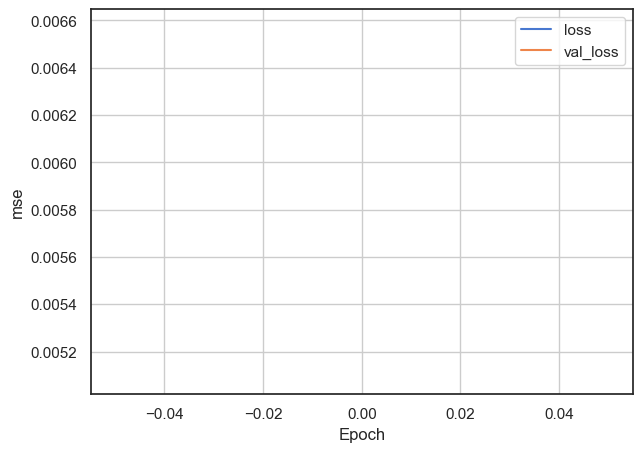

2/2 [==============================] - 4s 2s/step - loss: 0.0066 - mse: 0.0064


[0.006586404517292976, 0.006390586961060762]

18.503799438476562 MB
1/1 [==============================] - 0s 430ms/step


<Figure size 1000x300 with 0 Axes>

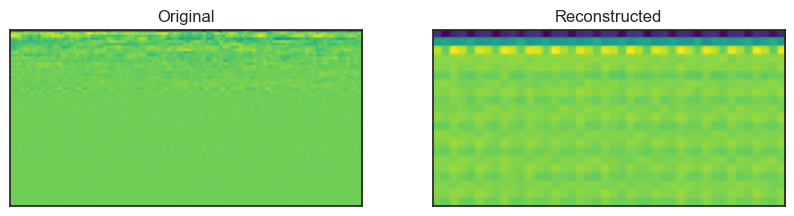

Creating the dataset from folder 02
dataset type <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
dataset type <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
dataset type <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
Create the dataset with 2000 files requires 350.04 seconds.


InvalidArgumentError: Graph execution error:

Detected at node 'AE_Conv_prep_flatten/Encoder/conv2d/Elu' defined at (most recent call last):
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\latta\AppData\Local\Temp\ipykernel_16252\694182428.py", line 26, in <module>
      US_training(AE_name = 'AE_Conv_prep_flatten', autoencoder = autoencoder, epochs = 1 , n_folders=2, preprocessing = preprocessing)
    File "g:\My Drive\Human_Data_Analytics_Project_2023\Models\ann_utils.py", line 1181, in US_training
      history = autoencoder.fit(train, validation_data= val, epochs=epochs, callbacks = callbacks, verbose=0)
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras\activations.py", line 148, in elu
      return backend.elu(x, alpha)
    File "c:\Users\latta\miniconda3\envs\tensorf_env\lib\site-packages\keras\backend.py", line 5392, in elu
      res = tf.nn.elu(x)
Node: 'AE_Conv_prep_flatten/Encoder/conv2d/Elu'
convolution input must be 4-dimensional: [128,64,128]
	 [[{{node AE_Conv_prep_flatten/Encoder/conv2d/Elu}}]] [Op:__inference_train_function_47958]

In [ ]:
best_params = {
    'n_layers':1,
    'n_units':64,
    'kernel_size':3,
    'strides':3,
    'max_pooling':3,
    'regularizer':0.0001,
    'padding':'valid',
    'code_size':128,
    'activation':'elu',
    'drop_out':0.25,
    'batch_norm':False,
    'learning_rate':0.00175,
}

# build an autoencoder with the best params
autoencoder = build_autoencoder(**best_params)

#autoencoder = tuner.get_best_models(num_models=1)[0] #to create the model with some already wuite good weights
autoencoder.summary()
verbose=0
if verbose>0:
    autoencoder.layers[1].summary()
    autoencoder.layers[2].summary()

US_training(AE_name = 'AE_Conv_prep_flatten', autoencoder = autoencoder, epochs = 1 , n_folders=2, preprocessing = preprocessing)

### Show the reconstruction capabilities of the model

Model: "Autoencoder_ffnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 220500, 1)]       0         
                                                                 
 sequential_10 (Sequential)  (None, 8)                 7056696   
                                                                 
 sequential_11 (Sequential)  (None, 220500, 1)         7277188   
                                                                 
Total params: 14,333,884
Trainable params: 14,333,884
Non-trainable params: 0
_________________________________________________________________


1/1 [==============================] - 0s 167ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 63ms/step


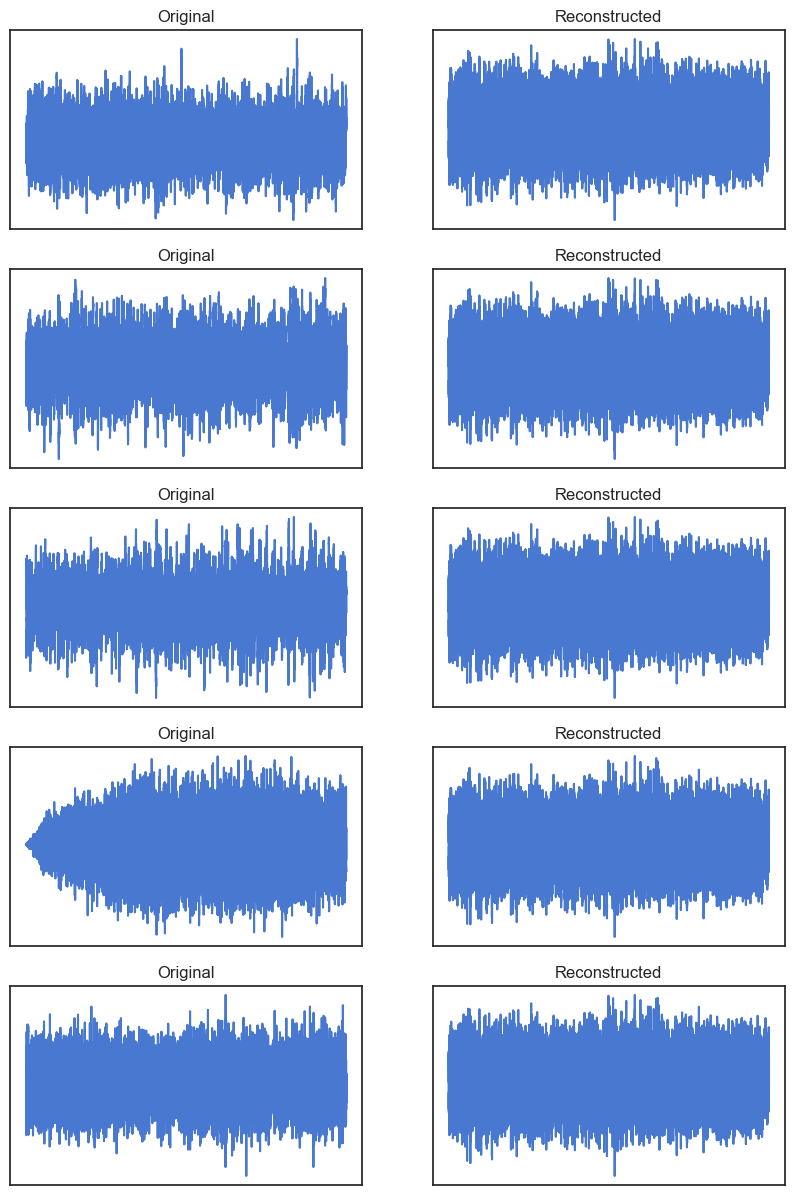

In [ ]:
#load the saved model
model_loaded = tf.keras.models.load_model(os.path.join(main_dir,'Saved_Models','AE_Conv_prep_flatten'))
model_loaded.summary()

#plot the original and reconstructed
plot_original_reconstructed(model = model_loaded, n_figures = 5, test=test)